# Analyzing Basketball Teams using Machine Learning 

In this project we shall be using basic machine learning algorithms to anaylze basketball teams. The hypothesis is that based on the different features, we can group and deduce the playstyles of different teams and assess their potential. 

NOTE: The algorithms used may not be what is best suited, but I am pretty new to this sooo

In [144]:
#Just importing libraries
from lxml import html
import requests
from bs4 import  BeautifulSoup
from bs4 import Comment
from time import sleep
from selenium import webdriver
import pandas as pd
from sklearn.cluster import KMeans       
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 

In [5]:
#A request function
def parse(url,driver):
    driver.get(url)
    sleep(3)
    sourceCode=driver.page_source
    return  sourceCode

In [6]:
#A function that will return our league yearly average stat data
def get_league_yearly_avg_data(url,driver):
        soup = BeautifulSoup(parse(url,driver),'lxml')
        table_entry = soup.find('table',id = "team-stats-per_game")
        table = table_entry.find_all('tr', limit =2 )
        headers = [th.getText() for th in table[0].find_all('th')]
        headers = headers[1:]
        rows = table_entry.find_all('tr')[1:]
        player_stats = [[td.getText() for td in rows[i].find_all('td')]for i in range(len(rows))]
        df = pd.DataFrame(player_stats, columns = headers)
        temp_df = df.dropna()
        df_cleaned = temp_df.drop(temp_df.index[-1])
        df_cleaned['Team'] = df_cleaned['Team'].replace('\*?','',regex = True)
        return df_cleaned

In [7]:
#A function that will return our league yearly rating(Off/Def/Net) data
def get_league_yearly_rating_data(url,driver):
    soup = BeautifulSoup(parse(url,driver),'lxml')
    table_entry = soup.find('table',id = "ratings")
    table = table_entry.find_all('tr', limit =2 )
    headers = [th.getText() for th in table[1].find_all('th')]
    headers = headers[1:]
    rows = table_entry.find_all('tr')[2:]
    player_stats = [[td.getText() for td in rows[i].find_all('td')]for i in range(len(rows))]
    df = pd.DataFrame(player_stats, columns = headers)
    df_cleaned = df.dropna()
    return df_cleaned

In [8]:
league_avg_dict = {}
driver = webdriver.Firefox(executable_path =r'C:\Users\User\Desktop\Basketball\geckodriver')
for i in range(1997,2021):
    year = i
    url = 'https://www.basketball-reference.com/leagues/NBA_{}.html'.format(year)
    league_avg_dict[str(year)] = get_league_yearly_avg_data(url,driver)

driver.close

len(league_avg_dict)

24

In [9]:
league_rating_dict = {}
driver = webdriver.Firefox(executable_path =r'C:\Users\User\Desktop\Basketball\geckodriver')
for i in range(1997,2021):
    year = i
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_ratings.html'.format(year)
    league_rating_dict[str(year)] = get_league_yearly_rating_data(url,driver)

driver.close

len(league_rating_dict)

24

In [10]:
key_list = [i for i in range(1997,2021)]
temp_list = []
for i in range(1997,2021):
    rating_df = league_rating_dict[str(i)]
    stat_df = league_avg_dict[str(i)]
    temp_df = pd.merge(rating_df, stat_df, on = 'Team')
    temp_list.append(temp_df)

combined_rating_avg_df = pd.concat(temp_list, keys = key_list)
combined_rating_avg_df

Team Conf Div   W   L  W/L%    MOV    ORtg    DRtg  \
1997 0           Chicago Bulls    E   C  69  13  .841  10.80  114.88  102.99   
     1               Utah Jazz    W   M  64  18  .780   8.79  114.41  104.75   
     2     Seattle SuperSonics    W   P  57  25  .695   7.68  112.02  103.67   
     3              Miami Heat    E   A  61  21  .744   5.49  107.67  101.38   
     4         Detroit Pistons    E   C  54  28  .659   5.24  111.44  105.29   
...                        ...  ...  ..  ..  ..   ...    ...     ...     ...   
2020 25        New York Knicks    E   A  21  45  .318  -6.45  107.10  113.52   
     26      Charlotte Hornets    E  SE  23  42  .354  -6.75  107.32  114.21   
     27          Atlanta Hawks    E  SE  20  47  .299  -7.97  107.86  115.47   
     28    Cleveland Cavaliers    E   C  19  46  .292  -7.89  108.14  116.20   
     29  Golden State Warriors    W   P  15  50  .231  -8.71  105.93  114.66   

          NRtg  ...   FT%   ORB   DRB   TRB   AST   STL  BLK   TOV    PF  \
1997 0   11.90  ...  .747  15.1  30.0  45.1  26.1   8.7  4.0  13.5  19.7   
     1    9.66  ...  .769  10.8  29.4  40.2  26.8   9.1  5.1  15.4  24.2   
     2    8.35  ...  .752  12.3  27.7  40.0  23.5  11.0  4.7  15.0  22.0   
     3    6.30  ...  .719  11.7  29.3  41.0  21.2   7.9  5.4  15.9  23.4   
     4    6.15  ...  .745  10.5  28.0  38.4  19.0   7.7  3.5  12.7  20.1   
...        ...  ...   ...   ...   ...   ...   ...   ...  ...   ...   ...   
2020 25  -6.42  ...  .694  12.0  34.5  46.5  22.1   7.6  4.7  14.3  22.2   
     26  -6.89  ...  .748  11.0  31.8  42.8  23.8   6.6  4.1  14.6  18.8   
     27  -7.61  ...  .790   9.9  33.4  43.3  24.0   7.8  5.1  16.2  23.1   
     28  -8.05  ...  .758  10.8  33.4  44.2  23.1   6.9  3.2  16.5  18.3   
     29  -8.74  ...  .803  10.0  32.9  42.8  25.6   8.2  4.6  14.9  20.1   

           PTS  
1997 0   103.1  
     1   103.1  
     2   100.9  
     3    94.8  
     4    94.2  
...        ...  
2020 25  105.8  
     26  102.9  
     27  111.8  
     28  106.9  
     29  106.3  

[712 rows x 37 columns]

We finally have a dataframe containing almost every metric used in basketball. We will now proceed to do some data cleaning and transforming the dataframe to suit our eventual needs.

In [11]:
combined_rating_avg_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 712 entries, (1997, 0) to (2020, 29)
Data columns (total 37 columns):
Team      712 non-null object
Conf      712 non-null object
Div       712 non-null object
W         712 non-null object
L         712 non-null object
W/L%      712 non-null object
MOV       712 non-null object
ORtg      712 non-null object
DRtg      712 non-null object
NRtg      712 non-null object
MOV/A     712 non-null object
ORtg/A    712 non-null object
DRtg/A    712 non-null object
NRtg/A    712 non-null object
G         712 non-null object
MP        712 non-null object
FG        712 non-null object
FGA       712 non-null object
FG%       712 non-null object
3P        712 non-null object
3PA       712 non-null object
3P%       712 non-null object
2P        712 non-null object
2PA       712 non-null object
2P%       712 non-null object
FT        712 non-null object
FTA       712 non-null object
FT%       712 non-null object
ORB       712 non-null object
DRB       

In [12]:
combined_rating_avg_df_copy = combined_rating_avg_df.copy()
combined_rating_avg_df_copy = combined_rating_avg_df_copy.apply(pd.to_numeric,errors = 'ignore')
combined_rating_avg_df_copy

Team Conf Div   W   L   W/L%    MOV    ORtg    DRtg  \
1997 0           Chicago Bulls    E   C  69  13  0.841  10.80  114.88  102.99   
     1               Utah Jazz    W   M  64  18  0.780   8.79  114.41  104.75   
     2     Seattle SuperSonics    W   P  57  25  0.695   7.68  112.02  103.67   
     3              Miami Heat    E   A  61  21  0.744   5.49  107.67  101.38   
     4         Detroit Pistons    E   C  54  28  0.659   5.24  111.44  105.29   
...                        ...  ...  ..  ..  ..    ...    ...     ...     ...   
2020 25        New York Knicks    E   A  21  45  0.318  -6.45  107.10  113.52   
     26      Charlotte Hornets    E  SE  23  42  0.354  -6.75  107.32  114.21   
     27          Atlanta Hawks    E  SE  20  47  0.299  -7.97  107.86  115.47   
     28    Cleveland Cavaliers    E   C  19  46  0.292  -7.89  108.14  116.20   
     29  Golden State Warriors    W   P  15  50  0.231  -8.71  105.93  114.66   

          NRtg  ...    FT%   ORB   DRB   TRB   AST   STL  BLK   TOV    PF  \
1997 0   11.90  ...  0.747  15.1  30.0  45.1  26.1   8.7  4.0  13.5  19.7   
     1    9.66  ...  0.769  10.8  29.4  40.2  26.8   9.1  5.1  15.4  24.2   
     2    8.35  ...  0.752  12.3  27.7  40.0  23.5  11.0  4.7  15.0  22.0   
     3    6.30  ...  0.719  11.7  29.3  41.0  21.2   7.9  5.4  15.9  23.4   
     4    6.15  ...  0.745  10.5  28.0  38.4  19.0   7.7  3.5  12.7  20.1   
...        ...  ...    ...   ...   ...   ...   ...   ...  ...   ...   ...   
2020 25  -6.42  ...  0.694  12.0  34.5  46.5  22.1   7.6  4.7  14.3  22.2   
     26  -6.89  ...  0.748  11.0  31.8  42.8  23.8   6.6  4.1  14.6  18.8   
     27  -7.61  ...  0.790   9.9  33.4  43.3  24.0   7.8  5.1  16.2  23.1   
     28  -8.05  ...  0.758  10.8  33.4  44.2  23.1   6.9  3.2  16.5  18.3   
     29  -8.74  ...  0.803  10.0  32.9  42.8  25.6   8.2  4.6  14.9  20.1   

           PTS  
1997 0   103.1  
     1   103.1  
     2   100.9  
     3    94.8  
     4    94.2  
...        ...  
2020 25  105.8  
     26  102.9  
     27  111.8  
     28  106.9  
     29  106.3  

[712 rows x 37 columns]

In [13]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

combined_rating_avg_df_numeric = combined_rating_avg_df_copy.select_dtypes(include=numerics)
useful_stat_columns = [
'ORtg',
'DRtg',
'NRtg' ,    
'ORtg/A',  
'DRtg/A',
'NRtg/A',    
'FG',     
'FGA',
'FG%',
'3P',   
'3PA',   
'3P%',    
'2P',
'2PA',    
'2P%',  
'FT',      
'FTA',     
'FT%',     
'ORB',       
'DRB',     
'TRB',     
'AST',    
'STL', 
'BLK',    
'TOV',  
'PF',    
'PTS'  
]
combined_rating_avg_df_numeric[useful_stat_columns]

ORtg    DRtg   NRtg  ORtg/A  DRtg/A  NRtg/A    FG   FGA    FG%  \
1997 0   114.88  102.99  11.90  115.01  103.19   11.82  40.0  84.4  0.473   
     1   114.41  104.75   9.66  113.94  105.23    8.72  38.2  75.8  0.504   
     2   112.02  103.67   8.35  111.50  104.03    7.47  36.5  78.2  0.467   
     3   107.67  101.38   6.30  107.71  101.31    6.40  34.4  76.0  0.453   
     4   111.44  105.29   6.15  111.68  105.30    6.38  34.5  74.3  0.464   
...         ...     ...    ...     ...     ...     ...   ...   ...    ...   
2020 25  107.10  113.52  -6.42  106.91  113.60   -6.70  40.0  89.3  0.447   
     26  107.32  114.21  -6.89  107.38  114.56   -7.18  37.3  85.9  0.434   
     27  107.86  115.47  -7.61  108.18  115.56   -7.37  40.6  90.6  0.449   
     28  108.14  116.20  -8.05  108.46  116.41   -7.94  40.3  87.9  0.458   
     29  105.93  114.66  -8.74  105.98  114.11   -8.13  38.6  88.2  0.438   

           3P  ...    FT%   ORB   DRB   TRB   AST   STL  BLK   TOV    PF  \
1997 0    6.4  ...  0.747  15.1  30.0  45.1  26.1   8.7  4.0  13.5  19.7   
     1    4.1  ...  0.769  10.8  29.4  40.2  26.8   9.1  5.1  15.4  24.2   
     2    6.8  ...  0.752  12.3  27.7  40.0  23.5  11.0  4.7  15.0  22.0   
     3    8.3  ...  0.719  11.7  29.3  41.0  21.2   7.9  5.4  15.9  23.4   
     4    7.1  ...  0.745  10.5  28.0  38.4  19.0   7.7  3.5  12.7  20.1   
...       ...  ...    ...   ...   ...   ...   ...   ...  ...   ...   ...   
2020 25   9.6  ...  0.694  12.0  34.5  46.5  22.1   7.6  4.7  14.3  22.2   
     26  12.1  ...  0.748  11.0  31.8  42.8  23.8   6.6  4.1  14.6  18.8   
     27  12.0  ...  0.790   9.9  33.4  43.3  24.0   7.8  5.1  16.2  23.1   
     28  11.2  ...  0.758  10.8  33.4  44.2  23.1   6.9  3.2  16.5  18.3   
     29  10.4  ...  0.803  10.0  32.9  42.8  25.6   8.2  4.6  14.9  20.1   

           PTS  
1997 0   103.1  
     1   103.1  
     2   100.9  
     3    94.8  
     4    94.2  
...        ...  
2020 25  105.8  
     26  102.9  
     27  111.8  
     28  106.9  
     29  106.3  

[712 rows x 27 columns]

In [14]:
combined_rating_avg_df_numeric[useful_stat_columns].corr()

,ORtg,DRtg,NRtg,ORtg/A,DRtg/A,NRtg/A,FG,FGA,FG%,3P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
ORtg,1.000000,0.174145,0.654975,0.998113,0.185429,0.660135,0.712284,0.329860,0.783702,0.596293,...,0.362544,-0.314689,0.430880,0.249381,0.454732,-0.049958,0.031720,-0.457643,-0.255799,0.804059
DRtg,0.174145,1.000000,-0.630043,0.198835,0.995837,-0.619795,0.363418,0.454191,0.026391,0.353210,...,0.186207,-0.118895,0.010437,-0.074244,0.011634,-0.239630,-0.266326,-0.023426,-0.004907,0.390200
NRtg,0.654975,-0.630043,1.000000,0.634540,-0.617947,0.996202,0.282859,-0.088406,0.597826,0.199186,...,0.142971,-0.156931,0.331796,0.253647,0.349714,0.144501,0.229415,-0.342873,-0.197934,0.334678
ORtg/A,0.998113,0.198835,0.634540,1.000000,0.209597,0.642720,0.711853,0.334020,0.777288,0.596956,...,0.368647,-0.311094,0.418395,0.238184,0.446486,-0.052964,0.021982,-0.456274,-0.252138,0.804144
DRtg/A,0.185429,0.995837,-0.617947,0.209597,1.000000,-0.614371,0.362070,0.448790,0.031123,0.361919,...,0.191771,-0.129839,0.010034,-0.082461,0.012171,-0.242464,-0.277166,-0.037195,-0.007661,0.393380
NRtg/A,0.660135,-0.619795,0.996202,0.642720,-0.614371,1.000000,0.290714,-0.082118,0.602825,0.198174,...,0.147249,-0.149387,0.329776,0.256771,0.350730,0.147206,0.234889,-0.339091,-0.197512,0.340683
FG,0.712284,0.363418,0.282859,0.711853,0.362070,0.290714,1.000000,0.811752,0.640848,0.670073,...,0.261131,-0.310928,0.671103,0.514765,0.656031,0.064702,0.054970,-0.270557,-0.273175,0.926779
FGA,0.329860,0.454191,-0.088406,0.334020,0.448790,-0.082118,0.811752,1.000000,0.073103,0.641428,...,0.181534,-0.062858,0.613692,0.628499,0.451706,0.096739,-0.018332,-0.216265,-0.216981,0.740663
FG%,0.783702,0.026391,0.597826,0.777288,0.031123,0.602825,0.640848,0.073103,1.000000,0.298673,...,0.202351,-0.444275,0.335003,0.051053,0.524636,-0.014214,0.116920,-0.179257,-0.178227,0.609052
3P,0.596293,0.353210,0.199186,0.596956,0.361919,0.198174,0.670073,0.641428,0.298673,1.000000,...,0.238279,-0.547179,0.695028,0.372359,0.395539,-0.059284,-0.102978,-0.272198,-0.358167,0.796241


From here we shall begin by first using K-means clustering(unsupervised machine learning) to let the computer determine trends in the teams

In [15]:
df = combined_rating_avg_df_numeric[useful_stat_columns]
X_std = StandardScaler().fit_transform(df)

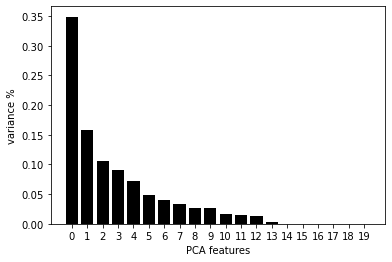

In [16]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_std)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
PCA_components = pd.DataFrame(principalComponents)

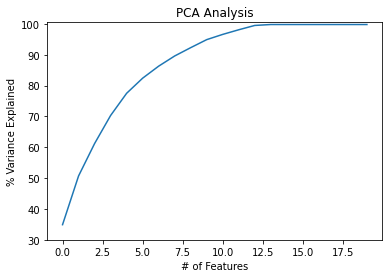

In [17]:
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')

plt.plot(var)

Text(0.5, 1.0, 'Elbow curve')

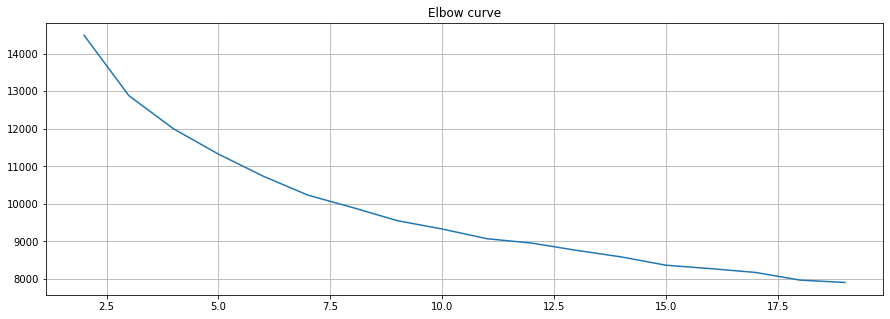

In [18]:
x= PCA_components.copy()
distortions = []
for k in range(2,20):
    kmeans = KMeans(n_clusters=k)    
    kmeans.fit(x.iloc[:,:12])                    
    distortions.append(kmeans.inertia_)   

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distortions)
plt.grid(True)
plt.title('Elbow curve')

In [19]:
k = 11

model = KMeans(n_clusters=k, random_state=0)

league_cluster_kmeans = model.fit(df)

print(league_cluster_kmeans)

KMeans(n_clusters=11, random_state=0)


In [20]:
combined_rating_avg_df_copy['label'] = league_cluster_kmeans.labels_
display(combined_rating_avg_df_copy.loc[2020])
display(combined_rating_avg_df_copy.loc[2010])

,Team,Conf,Div,W,L,W/L%,MOV,ORtg,DRtg,NRtg,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
0,Milwaukee Bucks,E,C,56,17,0.767,10.08,112.98,103.36,9.62,...,9.5,42.2,51.7,25.9,7.2,5.9,15.1,19.6,118.7,1
1,Los Angeles Clippers,W,P,49,23,0.681,6.44,114.66,108.25,6.41,...,10.7,37.0,47.7,23.7,7.1,4.7,14.6,22.1,116.3,1
2,Los Angeles Lakers,W,P,52,19,0.732,5.79,112.78,107.14,5.65,...,10.7,35.1,45.7,25.4,8.6,6.6,15.2,20.7,113.4,1
3,Toronto Raptors,E,A,53,19,0.736,6.24,112.02,105.85,6.18,...,9.5,35.9,45.4,25.2,8.8,5.0,14.8,21.7,112.8,1
4,Boston Celtics,E,A,48,24,0.667,6.31,114.14,107.79,6.35,...,10.7,35.4,46.1,23.0,8.3,5.6,13.8,21.6,113.7,1
5,Dallas Mavericks,W,SW,43,32,0.573,4.95,117.50,112.53,4.97,...,10.5,36.4,46.9,24.7,6.1,4.8,12.7,19.5,117.0,1
6,Houston Rockets,W,SW,44,28,0.611,2.96,113.71,110.82,2.89,...,9.8,34.5,44.3,21.6,8.7,5.2,14.7,21.8,117.8,1
7,Utah Jazz,W,NW,44,28,0.611,2.47,113.14,110.48,2.66,...,9.1,35.8,44.9,22.4,6.1,4.1,15.1,20.4,111.3,1
8,Miami Heat,E,SE,44,29,0.603,2.95,113.29,110.36,2.93,...,8.5,35.9,44.4,25.9,7.5,4.5,14.9,20.6,112.0,1
9,Oklahoma City Thunder,W,NW,44,28,0.611,1.99,111.74,109.66,2.09,...,8.2,34.7,42.9,21.7,7.6,4.9,13.7,19.3,110.4,1


,Team,Conf,Div,W,L,W/L%,MOV,ORtg,DRtg,NRtg,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
0,Orlando Magic,E,SE,59,23,0.720,7.49,112.13,104.00,8.13,...,9.9,33.4,43.2,19.7,6.2,5.6,14.1,19.9,102.8,2
1,Cleveland Cavaliers,E,C,61,21,0.744,6.52,112.27,105.07,7.21,...,9.6,32.8,42.5,22.4,6.9,5.2,13.9,19.4,102.1,2
2,Utah Jazz,W,NW,53,29,0.646,5.34,111.57,105.81,5.76,...,10.6,31.6,42.2,26.7,8.2,4.9,15.2,22.7,104.2,6
3,San Antonio Spurs,W,SW,50,32,0.610,5.09,110.61,105.17,5.44,...,10.8,32.0,42.8,22.3,6.3,4.6,13.6,20.4,101.4,6
4,Los Angeles Lakers,W,P,57,25,0.695,4.72,109.51,104.57,4.93,...,11.9,32.5,44.3,21.1,7.5,4.9,13.4,19.4,101.7,6
5,Phoenix Suns,W,P,54,28,0.659,4.90,116.11,110.94,5.16,...,11.1,31.9,43.0,23.3,5.8,5.1,14.8,20.9,110.2,9
6,Atlanta Hawks,E,SE,53,29,0.646,4.66,112.60,107.60,5.00,...,11.8,29.9,41.7,21.8,7.2,5.0,12.0,19.9,101.7,6
7,Denver Nuggets,W,NW,53,29,0.646,4.09,112.32,108.21,4.11,...,10.8,30.5,41.4,21.0,8.3,5.1,13.9,22.5,106.5,6
8,Oklahoma City Thunder,W,NW,50,32,0.610,3.49,109.18,105.43,3.75,...,11.7,31.8,43.5,20.0,8.0,5.9,15.0,21.3,101.5,6
9,Portland Trail Blazers,W,NW,50,32,0.610,3.30,111.91,108.02,3.88,...,11.1,29.1,40.2,20.4,6.4,4.3,12.3,20.9,98.1,6


In [21]:
centroids_df = pd.DataFrame(league_cluster_kmeans.cluster_centers_,columns = useful_stat_columns)

centroids_df['label'] = centroids_df.index

centroids_df.rank(ascending = False)

,ORtg,DRtg,NRtg,ORtg/A,DRtg/A,NRtg/A,FG,FGA,FG%,3P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
0,8.0,7.0,8.0,7.0,7.0,8.0,6.0,5.0,6.0,11.0,...,1.0,9.0,6.0,7.0,2.0,2.0,6.0,1.0,8.0,11.0
1,1.0,3.0,4.0,1.0,3.0,4.0,1.0,1.0,3.0,1.0,...,10.0,1.0,1.0,1.0,5.0,4.0,7.0,8.0,1.0,10.0
2,3.0,9.0,1.0,3.0,9.0,1.0,4.0,7.0,1.0,3.0,...,9.0,3.0,4.0,5.0,7.0,3.0,8.0,11.0,4.0,9.0
3,6.0,1.0,10.0,6.0,1.0,10.0,3.0,2.0,9.0,2.0,...,11.0,2.0,5.0,3.0,8.0,11.0,5.0,9.0,3.0,8.0
4,7.0,11.0,2.0,8.0,11.0,2.0,9.0,10.0,5.0,9.0,...,3.0,5.0,3.0,4.0,1.0,1.0,4.0,6.0,9.0,7.0
5,11.0,5.0,11.0,11.0,5.0,11.0,10.0,9.0,11.0,10.0,...,2.0,11.0,9.0,11.0,4.0,6.0,1.0,2.0,11.0,6.0
6,2.0,8.0,3.0,2.0,8.0,3.0,5.0,8.0,2.0,6.0,...,5.0,7.0,7.0,6.0,3.0,5.0,11.0,4.0,5.0,5.0
7,9.0,2.0,9.0,9.0,2.0,9.0,7.0,4.0,8.0,7.0,...,4.0,10.0,10.0,9.0,11.0,10.0,2.0,5.0,7.0,4.0
8,10.0,10.0,5.0,10.0,10.0,5.0,11.0,11.0,10.0,8.0,...,6.0,8.0,11.0,10.0,9.0,7.0,3.0,3.0,10.0,3.0
9,4.0,4.0,6.0,4.0,4.0,6.0,2.0,3.0,4.0,4.0,...,8.0,4.0,2.0,2.0,6.0,8.0,10.0,10.0,2.0,2.0


label 0 = ass(poor offense(probably a lot of driving but unable to shoot FTs)and defense)

label 1 = pogchamp stats( good perimeter offense with defense)

label 2 = slightly more balanced on offense then label 1

label 3 = decent offense with atrocious defense

label 4 = old school midrange with defense

label 5 = ass(poor offense(probably playing old school mid range poorly)and defense)

label 6 = offense that negates poor defense

label 7 = defense but poor offense

label 8 = balance(poor in everything)

label 9 = balance(good in everything)

label 10 = balance(avg at everything)


In [22]:
championship_teams_df = pd.read_csv('ChampionshipTeams.csv', names = ['year', 'team'])
championship_teams_df = championship_teams_df.iloc[::-1].reset_index(drop = True)
championship_teams_series = championship_teams_df['team']
championship_teams_dict = {year: team for year,team in enumerate(list(championship_teams_series),start = 1997)}
championship_teams_dict


{1997: 'Chicago Bulls',
 1998: 'Chicago Bulls',
 1999: 'San Antonio Spurs',
 2000: 'Los Angeles Lakers',
 2001: 'Los Angeles Lakers',
 2002: 'Los Angeles Lakers',
 2003: 'San Antonio Spurs',
 2004: 'Detroit Pistons',
 2005: 'San Antonio Spurs',
 2006: 'Miami Heat',
 2007: 'San Antonio Spurs',
 2008: 'Boston Celtics',
 2009: 'Los Angeles Lakers',
 2010: 'Los Angeles Lakers',
 2011: 'Dallas Mavericks',
 2012: 'Miami Heat',
 2013: 'Miami Heat',
 2014: 'San Antonio Spurs',
 2015: 'Golden State Warriors',
 2016: 'Cleveland Cavaliers',
 2017: 'Golden State Warriors',
 2018: 'Golden State Warriors',
 2019: 'Toronto Raptors',
 2020: 'Los Angeles Lakers'}

In [23]:
champion_only_df = pd.DataFrame()
for year, team in championship_teams_dict.items():
    temp = combined_rating_avg_df_copy.loc[int(year)]
    row = temp[temp['Team'] == team]
    champion_only_df = champion_only_df.append(row)

champion_only_df['Year'] = championship_teams_dict.keys()
champion_only_df = champion_only_df.set_index('Year', drop= True)
champion_only_df

,Team,Conf,Div,W,L,W/L%,MOV,ORtg,DRtg,NRtg,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
Year,,,,,,,,,,,,,,,,,,,,,
1997,Chicago Bulls,E,C,69,13,0.841,10.80,114.88,102.99,11.90,...,15.1,30.0,45.1,26.1,8.7,4.0,13.5,19.7,103.1,6
1998,Chicago Bulls,E,C,62,20,0.756,7.11,108.71,100.86,7.85,...,15.2,29.7,44.9,23.8,8.5,4.3,14.4,20.6,96.7,4
1999,San Antonio Spurs,W,M,37,13,0.740,8.06,105.08,95.90,9.19,...,12.3,31.7,44.0,22.0,8.4,7.0,15.2,20.2,92.8,4
2000,Los Angeles Lakers,W,P,67,15,0.817,8.55,107.85,98.79,9.05,...,13.6,33.4,47.0,23.4,7.5,6.5,13.9,22.5,100.8,4
2001,Los Angeles Lakers,W,P,56,26,0.683,3.38,109.15,105.56,3.59,...,13.2,31.5,44.7,23.0,6.9,6.0,14.4,22.8,100.6,6
2002,Los Angeles Lakers,W,P,58,24,0.707,7.12,110.29,102.52,7.77,...,12.5,31.8,44.3,23.0,7.6,5.8,12.7,22.2,101.3,6
2003,San Antonio Spurs,W,M,60,22,0.732,5.41,106.25,100.29,5.96,...,11.5,31.2,42.6,20.0,7.7,6.5,15.8,20.4,95.8,4
2004,Detroit Pistons,E,C,54,28,0.659,5.84,103.18,96.48,6.70,...,12.4,30.4,42.8,20.8,8.0,7.0,15.1,20.3,90.1,4
2005,San Antonio Spurs,W,SW,59,23,0.720,7.80,108.45,99.59,8.85,...,12.0,30.4,42.4,21.6,7.5,6.6,13.7,20.9,96.2,4


In [24]:
pd.set_option('display.max_columns', None)
display(centroids_df.rank(ascending = False).iloc[[1,2,4,6]])

,ORtg,DRtg,NRtg,ORtg/A,DRtg/A,NRtg/A,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
1,1.0,3.0,4.0,1.0,3.0,4.0,1.0,1.0,3.0,1.0,1.0,3.0,8.0,11.0,1.0,7.0,9.0,1.0,10.0,1.0,1.0,1.0,5.0,4.0,7.0,8.0,1.0,10.0
2,3.0,9.0,1.0,3.0,9.0,1.0,4.0,7.0,1.0,3.0,3.0,1.0,9.0,9.0,2.0,5.0,6.0,5.0,9.0,3.0,4.0,5.0,7.0,3.0,8.0,11.0,4.0,9.0
4,7.0,11.0,2.0,8.0,11.0,2.0,9.0,10.0,5.0,9.0,9.0,6.0,3.0,3.0,8.0,3.0,3.0,10.0,3.0,5.0,3.0,4.0,1.0,1.0,4.0,6.0,9.0,7.0
6,2.0,8.0,3.0,2.0,8.0,3.0,5.0,8.0,2.0,6.0,7.0,2.0,2.0,5.0,5.0,1.0,1.0,4.0,5.0,7.0,7.0,6.0,3.0,5.0,11.0,4.0,5.0,5.0


INSIGHT:
All championship teams so far for the past 24 years fall under the clusters 1,2,4,6. Conincidence? Maybe 
However looking closely at the centroid data we can see why this might make sense. All of these 4 clusters have an extremely high net rating, ranking in the top 4 . This means that each of these teams per 100 possessions is usually going to emerge with a lead, the exact number dependent on their actual net rating. And since the team that lead by the end of the game wins, hence it explains why they are champions.

NOTE: However looking at the dataset for only 2020, we can see that many of the teams are also with label 1. Does that make of all the teams in 2020 champion teams? Not really. This occurred because we used many teams data over a span of 24 yrs. It is a known fact that over the years scores have become inflated due to increasing talent and rule changes.

So rather the difference in cluster numbers in the champions dataframe over the years should be viewed as changes in the era. 

An example is how from 1997 till 2004, the champion teams were all from clusters 4 and 6. What is notable from this two clusters is their high net rating, poor 3P%, avg to poor 2P%, great defense and high FTA. This is in line with what we know about old school basketball where teams shoot 3 pointers infrequently, playing more in the paint and the midrange. This would result in high FTA as there is a high possibility of getting fouled driving or shooting a midrange. Defense was also more of an emphasis before rules such as handchecking and 3s paint rule came into play 

Afterwards, there begin to appear more from cluster 1 and 2, where the emphasis begin to shift towards the 3P line. Floor spacing is more valued allowing for greater operation in the paint. Offensive rebounding is less prominent as Centers no longer always sit in the paint. Likewise Defensive rebounding is ranked highly as opponent team Centers no longer always sit in the paint to rebound. 

The bottom line is that for a team to contend, the most prominent sign of success is probably their net rating. For the modern NBA, following the trend the past few years, a team that is in cluster 1 has a high chance. High chance not only because of the cluster's net rating ranking though, but more so because of their 3P emphasis. The ability to shoot and space the floor appears to be essential for the modern NBA. Another is the defensive ability to make sure they are not outgunned. While the team with the highest net rating that year may not always be the champion, or even among the conference final teams(eg. The 2020 Milwaukee Bucks), minimally to make the playoffs one should at least have a positive or close to zero net rating. If your net rating is a negative 3 or 4 do not expect to make the playoffs.

Now we shall attempt to use linear regression to predict the stats of what the NBA champion in 2021 might average at the end of next season. We shall use the stats of both the champion and runnerup from the year 2013 to 2020. This is because from the year 2013 onwards, the labels 1 or 2 appear to be the norm. Indicative that label 1 and 2 represent the current playstyle of the NBA.  If we were to take data further back then 2012, the predicted results might be affected as the playstyle is different and the data used for the model will be affectd. We want to predict based on the modern playstyle and its resultant averages 

In [25]:
selected_features = [
  'ORtg/A',  
'DRtg/A',
'NRtg/A',    
'FG',     
'FGA',
'FG%',
'3P',   
'3PA',   
'3P%',    
'2P',
'2PA',    
'2P%',  
'FT',      
'FTA',     
'FT%',     
'ORB',       
'DRB',     
'TRB',     
'AST',    
'STL', 
'BLK',    
'TOV',  
'PF',    
'PTS'  
]

In [46]:
url = 'https://www.sportskeeda.com/basketball/nba-champions-and-runners-up'
soup = BeautifulSoup(parse(url,driver),'lxml')
table_entry = soup.find('table')
table = table_entry.find_all('tr',limit = 2)
headers = [td.getText() for td in table[0].find_all('td')]
rows = table_entry.find_all('tr')[1:]
top_two_team_list = [[td.getText() for td in rows[i].find_all('td')]for i in range(len(rows))]
top_two_team_df = pd.DataFrame(top_two_team_list, columns = headers).set_index('Year')
top_two_team_df.to_csv('NBA_Champs_and_Runnerups.csv')

Added in additional details for 2019 and 2020 to the saved CSV

In [61]:
champ_runnerup_df = pd.read_csv('NBA_Champs_and_Runnerups.csv')

,Year,Champion,Runner-up
0,1947,Philadelphia Warriors,Chicago Stags
1,1948,Baltimore Bullets,Philadelphia Warriors
2,1949,Minneapolis Lakers,Washington Capitols
3,1950,Minneapolis Lakers,Syracuse Nationals
4,1951,Rochester Royals,New York Knicks
...,...,...,...
69,2016,Cleveland Cavaliers,Golden State Warriors
70,2017,Golden State Warriors,Cleveland Cavaliers
71,2018,Golden State Warriors,Cleveland Cavaliers
72,2019,Toronto Raptors,Golden State Warriors


In [62]:
last_7seasons_winners_df = champ_runnerup_df.set_index('Year').loc[[year for year in range(2013,2021)]]

In [168]:
last_7seasons_winners_dict = last_7seasons_winners_df.to_dict()

In [99]:
runnerup_df = pd.DataFrame()
champ_df = pd.DataFrame()
for status, Dict in last_7seasons_winners_dict.items():
    if status == 'Champion':
        for year, team in Dict.items():
            temp = combined_rating_avg_df_copy.loc[int(year)]
            row = temp[temp['Team'] == team]
            champ_df = champ_df.append(row)
    else:
        for year, team in Dict.items():
            temp = combined_rating_avg_df_copy.loc[int(year)]
            row = temp[temp['Team'] == team]
            runnerup_df = runnerup_df.append(row)

key_list = [i for i in range(2013,2021)]
runnerup_df['Year'] = key_list

champ_df['Year'] = key_list

champ_runnerup_df = pd.concat([runnerup_df,champ_df])
champ_runnerup_df = champ_runnerup_df.reset_index()
champ_runnerup_df = champ_runnerup_df.sort_values('Year')

In [159]:
all_y = champ_runnerup_df[selected_features]
all_x = champ_runnerup_df[['Year']]

In [160]:
X_train, X_test, y_train, y_test = train_test_split(all_x,all_y, random_state =42)

In [161]:
lrm = linear_model.LinearRegression()
lrm.fit(X_train,y_train)

LinearRegression()

In [169]:
#print(lrm.coef_)
#print(lrm.intercept_)

In [163]:
predicted_y = lrm.predict(X_test)

In [189]:
display(pd.DataFrame(lrm.predict([[2021]]) , columns = [selected_features]))
print('-'*50 + "Predicted average" +'-'*50)
display(centroids_df[centroids_df['label'] ==1])
print('-'*50 + "Cluster 1 average" +'-'*50)
display(champ_runnerup_df[selected_features].iloc[[-1]])
print('-'*50 + "2020 LA Lakers average" +'-'*50)

,ORtg/A,DRtg/A,NRtg/A,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,115.584117,110.519748,5.069049,43.919029,91.126796,0.482392,13.688544,36.971262,0.36801,30.278447,54.119029,0.557893,17.602718,22.552427,0.783581,9.860777,36.977476,46.762524,28.015922,8.05301,6.563495,14.54,20.967767,119.167767


--------------------------------------------------Predicted average--------------------------------------------------


,ORtg,DRtg,NRtg,ORtg/A,DRtg/A,NRtg/A,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,label
1,112.494262,110.103443,2.391311,112.486066,110.124098,2.361803,41.160656,88.555738,0.464984,12.106557,33.529508,0.361607,29.052459,55.022951,0.528672,18.088525,23.542623,0.768902,10.22623,35.032787,45.24918,24.865574,7.745902,5.072131,14.337705,20.67541,112.52459,1


--------------------------------------------------Cluster 1 average--------------------------------------------------


,ORtg/A,DRtg/A,NRtg/A,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
15,112.83,106.68,6.16,42.3,88.3,0.48,11.0,31.6,0.349,31.3,56.7,0.552,17.7,24.3,0.729,10.7,35.1,45.7,25.4,8.6,6.6,15.2,20.7,113.4


--------------------------------------------------2020 LA Lakers average--------------------------------------------------


By using very simple linear Regression on the stats of the championship teams from 2013 to 2020, the above is a prediction of stats of the 2021 team. 